In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Brain Tumor Detection/lgg-mri-segmentation'

/content/drive/MyDrive/Brain Tumor Detection/lgg-mri-segmentation


## 1. Importing Necessary libraries

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(tf.test.gpu_device_name())
tf.device('/device:GPU:0')
tf.debugging.set_log_device_placement(True)

tf.random.set_seed(0)
np.random.seed(0)

/device:GPU:0


In [ ]:
IMAGE_SIZE = (256, 256)

## 2. Creating DataFrame

In [ ]:
with tf.device('/device:GPU:0'):
    mask_files = glob('/content/drive/MyDrive/Brain Tumor Detection/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
    train_files = [file.replace('_mask', '') for file in mask_files]

In [ ]:
from IPython.display import clear_output
with tf.device('/device:GPU:0'):
    count =0
    def diagnosis(mask_path):
        global count
        count += 1
        clear_output(wait=True)
        print(count,'/', len(train_files))
        value = np.max(cv2.imread(mask_path))
        return '1' if value > 0 else '0'
    df = pd.DataFrame({"image_path": train_files,
                    "mask_path": mask_files,
                    "diagnosis":[diagnosis(x) for x in mask_files]})
    df.to_csv('tumor.csv', index=False)
    df.head()

3929 / 3929


In [ ]:
df = pd.read_csv('tumor.csv')
df.head()

image_path  \
0  /content/drive/MyDrive/Brain Tumor Detection/l...   
1  /content/drive/MyDrive/Brain Tumor Detection/l...   
2  /content/drive/MyDrive/Brain Tumor Detection/l...   
3  /content/drive/MyDrive/Brain Tumor Detection/l...   
4  /content/drive/MyDrive/Brain Tumor Detection/l...   

                                           mask_path  diagnosis  
0  /content/drive/MyDrive/Brain Tumor Detection/l...          0  
1  /content/drive/MyDrive/Brain Tumor Detection/l...          0  
2  /content/drive/MyDrive/Brain Tumor Detection/l...          1  
3  /content/drive/MyDrive/Brain Tumor Detection/l...          1  
4  /content/drive/MyDrive/Brain Tumor Detection/l...          1

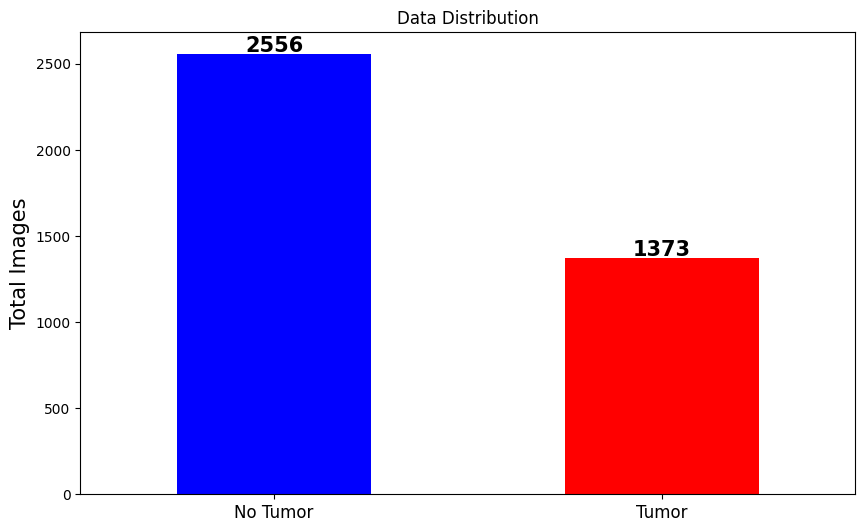

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Visualizing MRI with Mask

In [ ]:
df.head()

image_path  \
0  /content/drive/MyDrive/Brain Tumor Detection/l...   
1  /content/drive/MyDrive/Brain Tumor Detection/l...   
2  /content/drive/MyDrive/Brain Tumor Detection/l...   
3  /content/drive/MyDrive/Brain Tumor Detection/l...   
4  /content/drive/MyDrive/Brain Tumor Detection/l...   

                                           mask_path  diagnosis  
0  /content/drive/MyDrive/Brain Tumor Detection/l...          0  
1  /content/drive/MyDrive/Brain Tumor Detection/l...          0  
2  /content/drive/MyDrive/Brain Tumor Detection/l...          1  
3  /content/drive/MyDrive/Brain Tumor Detection/l...          1  
4  /content/drive/MyDrive/Brain Tumor Detection/l...          1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1882 non-null   object
 1   mask_path   1882 non-null   object
 2   diagnosis   1882 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 44.2+ KB


In [ ]:
len(mask_files),len(train_files)

(3929, 3929)

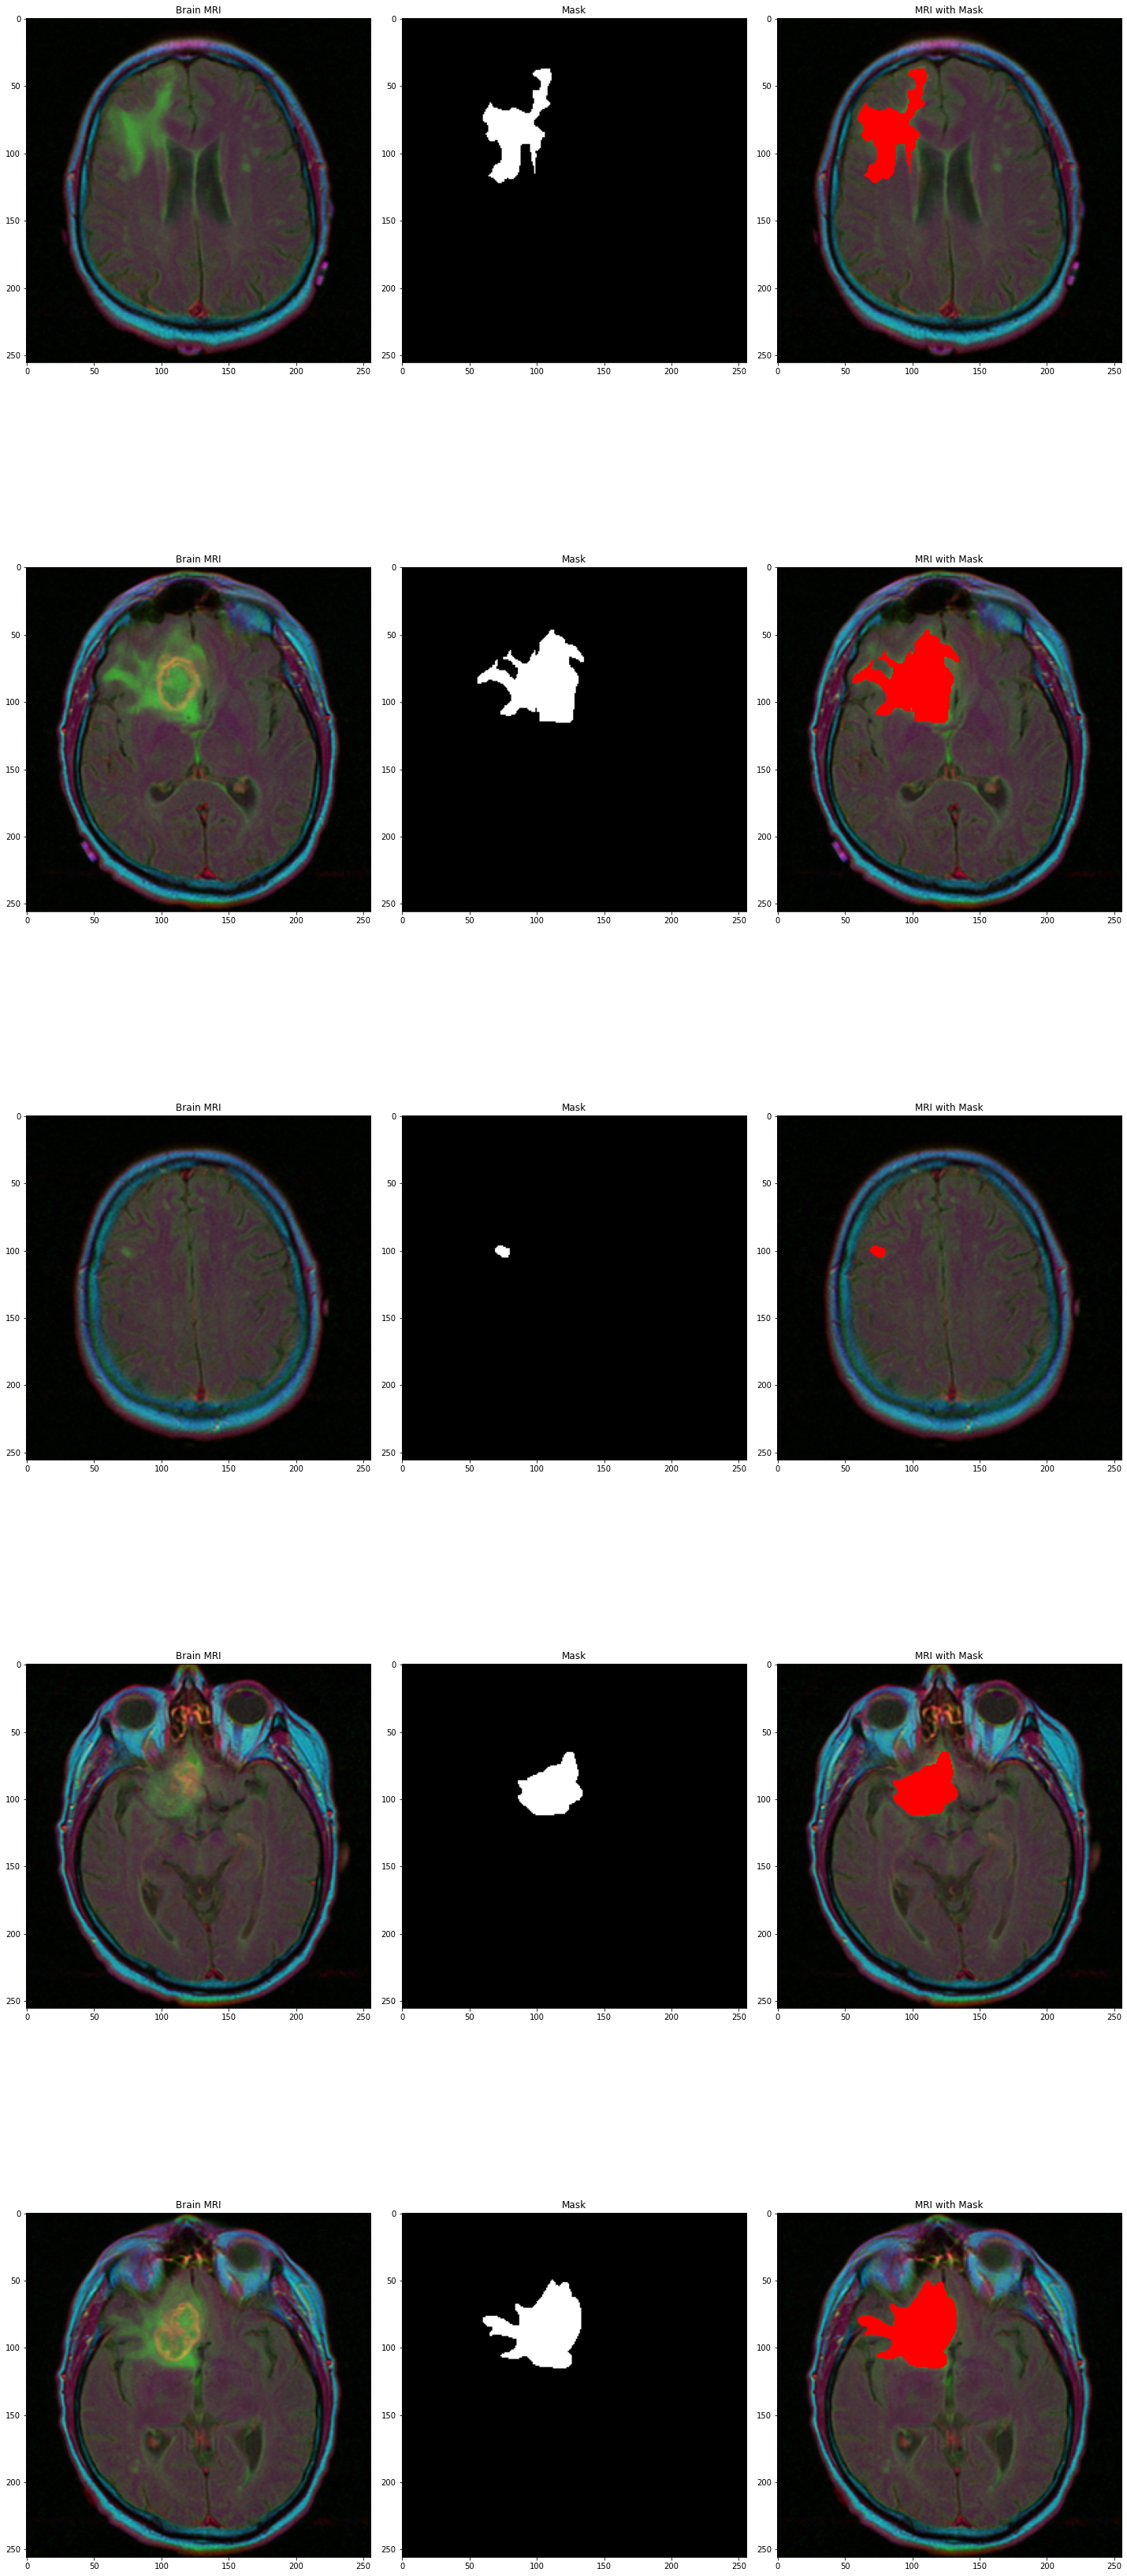

In [ ]:
from skimage import io
df_positive = df[df['diagnosis']==1].head()
df_negative = df[df['diagnosis']==0].head()

count = 0
fig, axs = plt.subplots(5, 3, figsize = (20, 50))
for i in range(len(df_positive)):
    img = cv2.imread(df_positive.image_path.iloc[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(df_positive.mask_path.iloc[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    img[mask == 255] = (255, 0, 0) #Red color
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

### Splitting data into Train, Validation and Test Set

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


## 3. Classification


In [ ]:
IMAGE_SIZE_CLASS = (200,200)
from skimage import io

X = []
Y = []
for i in range(len(df)):
  print(i)
  img = cv2.imread(df.image_path.iloc[i])
  img = cv2.resize(img, IMAGE_SIZE_CLASS)
  X.append(img)
  Y.append(df.diagnosis.iloc[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
X = np.array(X).reshape(-1, IMAGE_SIZE_CLASS[0], IMAGE_SIZE_CLASS[1], 3)
X = X.astype('float32')
X /= 255

#### a) Splitting data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X,Y, test_size=0.15,random_state=42)
X_train_class, X_val_class, Y_train_class, Y_val_class = train_test_split(X_train_class,Y_train_class, test_size=0.15)

In [ ]:
print ("Shape of an image in X_train: ", X_train_class[0].shape)
print ("Shape of an image in X_test: ", X_test_class[0].shape)

Shape of an image in X_train:  (200, 200, 3)
Shape of an image in X_test:  (200, 200, 3)


In [ ]:
Y_train_class = np.array(Y_train_class)
X_train_class = np.array(X_train_class)
Y_val_class = np.array(Y_val_class)
X_val_class = np.array(X_val_class) 
X_test_class = np.array(X_test_class)
Y_test_class = np.array(Y_test_class)

#### b) Model Training

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1,  activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train_class,Y_train_class,epochs=20,validation_data=(X_val_class,Y_val_class))

Epoch 1/20
89/89 [==============================] - 9s 63ms/step - loss: 0.4875 - accuracy: 0.7424 - val_loss: 0.3650 - val_accuracy: 0.8124
Epoch 2/20
89/89 [==============================] - 5s 55ms/step - loss: 0.3598 - accuracy: 0.8238 - val_loss: 0.2781 - val_accuracy: 0.8623
Epoch 3/20
89/89 [==============================] - 5s 57ms/step - loss: 0.2623 - accuracy: 0.8767 - val_loss: 0.2832 - val_accuracy: 0.8643
Epoch 4/20
89/89 [==============================] - 5s 56ms/step - loss: 0.1919 - accuracy: 0.9204 - val_loss: 0.2268 - val_accuracy: 0.9002
Epoch 5/20
89/89 [==============================] - 5s 55ms/step - loss: 0.1619 - accuracy: 0.9348 - val_loss: 0.2665 - val_accuracy: 0.8942
Epoch 6/20
89/89 [==============================] - 5s 56ms/step - loss: 0.1481 - accuracy: 0.9405 - val_loss: 0.2788 - val_accuracy: 0.8762
Epoch 7/20
89/89 [==============================] - 5s 54ms/step - loss: 0.0870 - accuracy: 0.9686 - val_loss: 0.2943 - val_accuracy: 0.8862
Epoch 8/20
89

In [29]:
Y_predict_class = model.predict(X_test_class)
score = model.evaluate(X_test_class, Y_test_class, verbose = 0 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])


19/19 [==============================] - 0s 15ms/step
Test Score:  0.3431195020675659
Test accuracy:  0.9135593175888062


Text(0.5, 1.0, 'Loss')

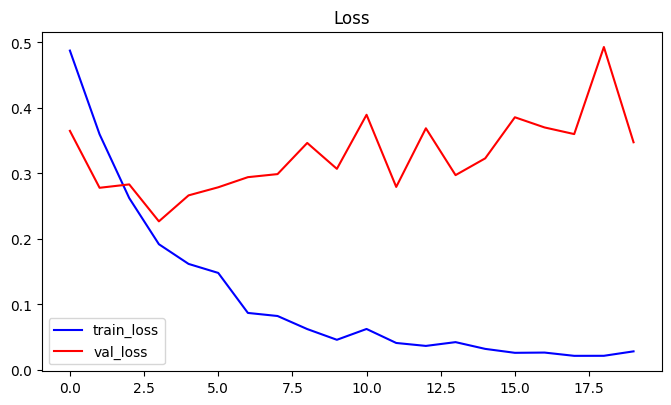

In [30]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(history.history['loss'], 'b-', label='train_loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')


Text(0.5, 1.0, 'accuracy')

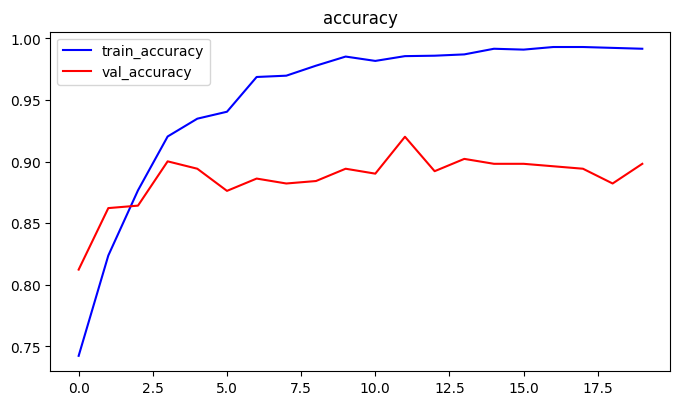

In [31]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(history.history['accuracy'], 'b-', label='train_accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='val_accuracy')
plt.legend(loc='best')
plt.title('accuracy')


## 4. Segmentation

####  a) U-Net Model

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### b) U-Net Model Architecture

![](https://i.imgur.com/lKZGO0C.png)

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## 5. Model Training

In [ ]:
# Set parameters
EPOCHS = 150
BATCH_SIZE = 16
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

with tf.device('/device:GPU:0'):
    history = model.fit(train_gen,
                        steps_per_epoch=len(df_train) / BATCH_SIZE, 
                        epochs=EPOCHS, 
                        callbacks=callbacks,
                        validation_data = val_gen,
                        validation_steps=len(df_val) / BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/150


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


178/177 [==============================] - ETA: -8s - loss: 1.1590 - iou: 0.0425 - dice_coef: 0.0804Found 501 validated image filenames.
Found 501 validated image filenames.
177/177 [==============================] - 2888s 16s/step - loss: 1.1590 - iou: 0.0425 - dice_coef: 0.0804 - val_loss: 1.3518 - val_iou: 0.0117 - val_dice_coef: 0.0230 - lr: 1.0000e-04
Epoch 2/150
177/177 [==============================] - 146s 822ms/step - loss: 0.9718 - iou: 0.0777 - dice_coef: 0.1420 - val_loss: 1.0561 - val_iou: 0.0330 - val_dice_coef: 0.0628 - lr: 1.0000e-04
Epoch 3/150
177/177 [==============================] - 146s 826ms/step - loss: 0.8882 - iou: 0.1099 - dice_coef: 0.1943 - val_loss: 0.8793 - val_iou: 0.1097 - val_dice_coef: 0.1937 - lr: 1.0000e-04
Epoch 4/150
177/177 [==============================] - 145s 818ms/step - loss: 0.8021 - iou: 0.1526 - dice_coef: 0.2594 - val_loss: 0.8000 - val_iou: 0.1433 - val_dice_coef: 0.2431 - lr: 1.0000e-04
Epoch 5/150
177/177 [==========================

In [ ]:
model.save('final_model')
model.save('final_model.h5')

## 6. Visualizing Model Performance

Text(0.5, 1.0, 'Dice Coef')

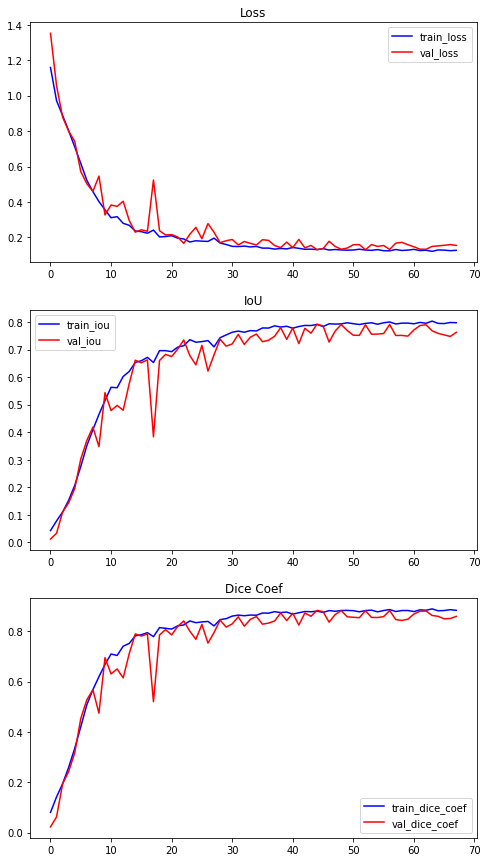

In [ ]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

## 7. Model Evaluation

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
36/36 [==============================] - 494s 14s/step - loss: 0.1419 - iou: 0.7732 - dice_coef: 0.8702
Test IOU:  0.7732250094413757
Test Dice Coefficent:  0.8701940178871155


##8. Visualizing the Result

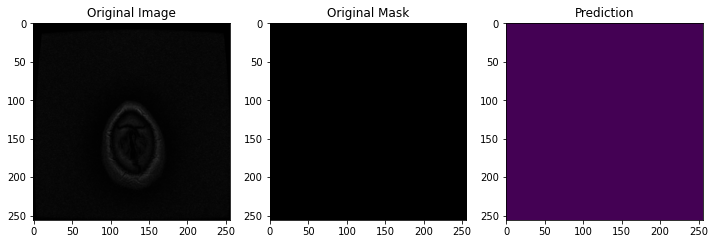

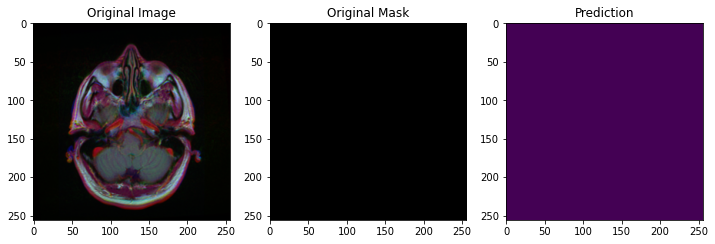

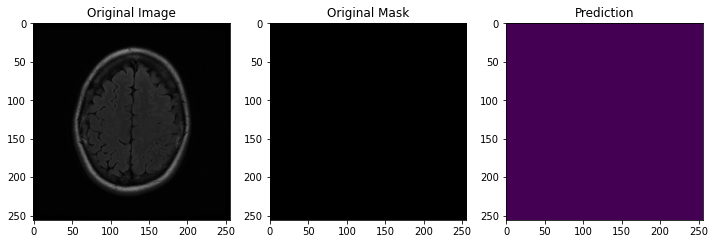

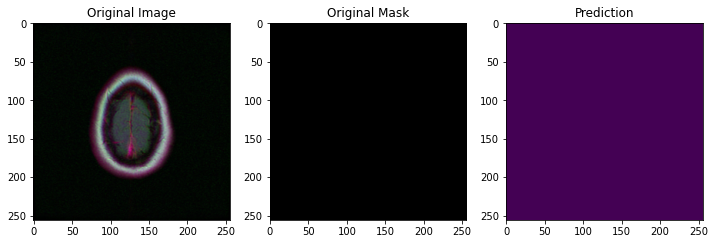

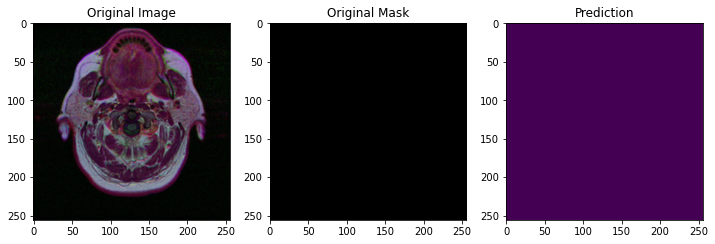

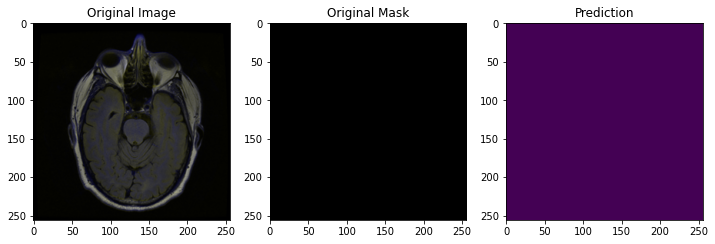

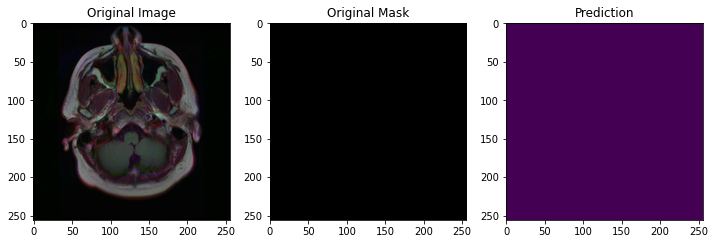

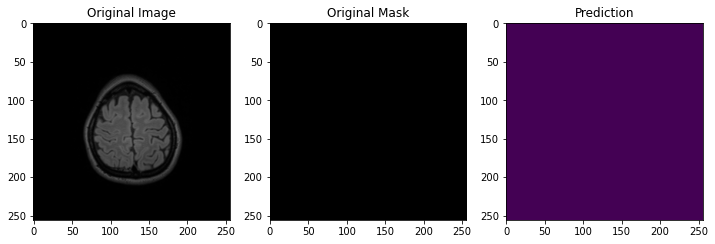

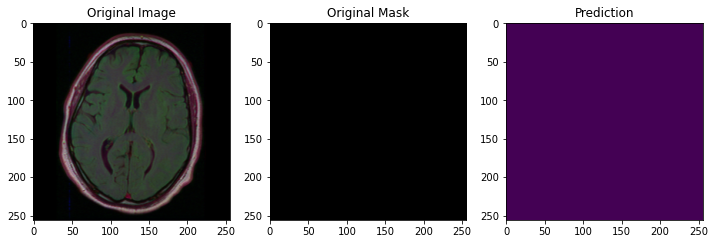

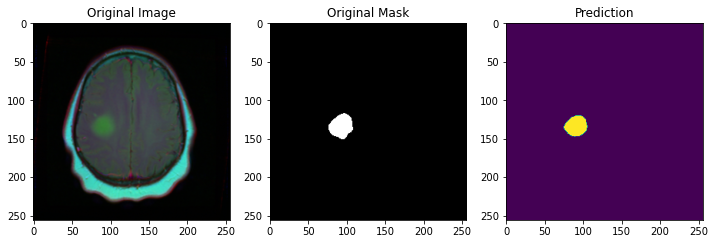

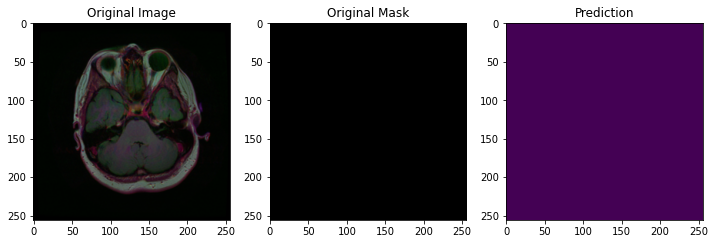

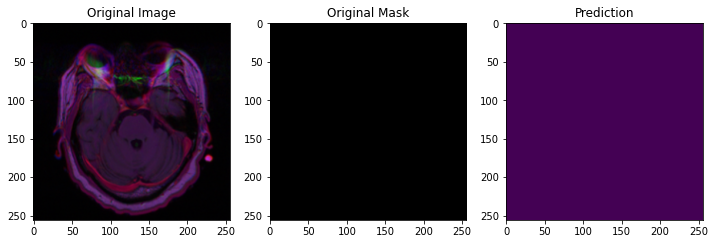

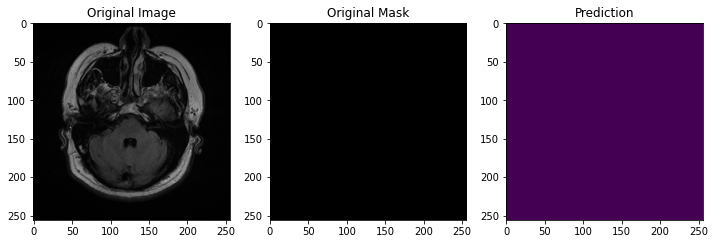

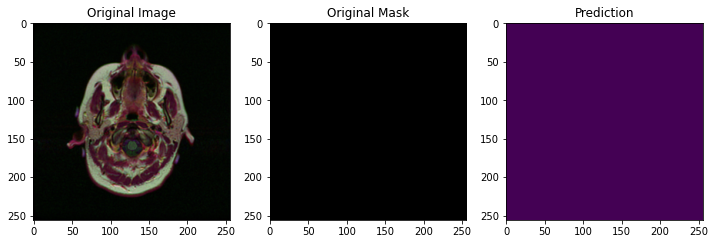

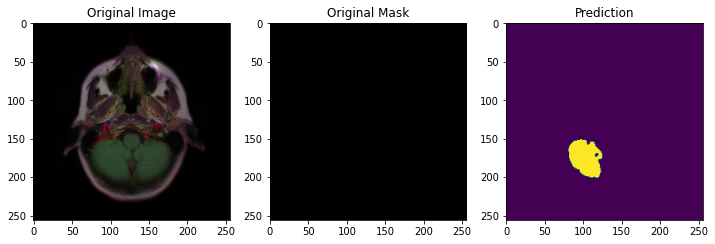

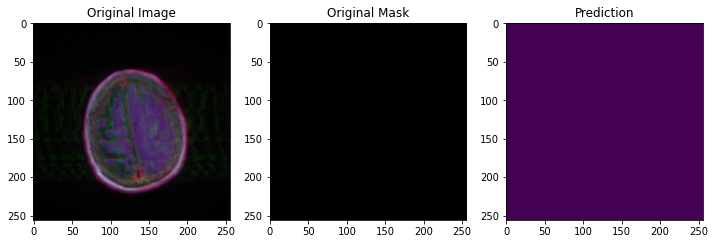

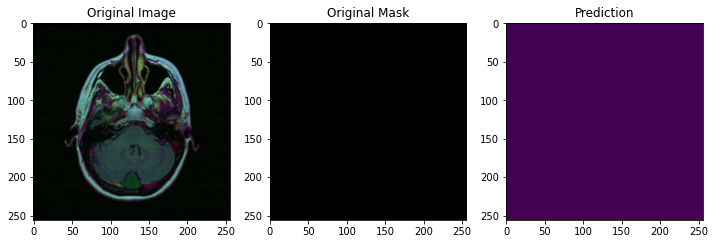

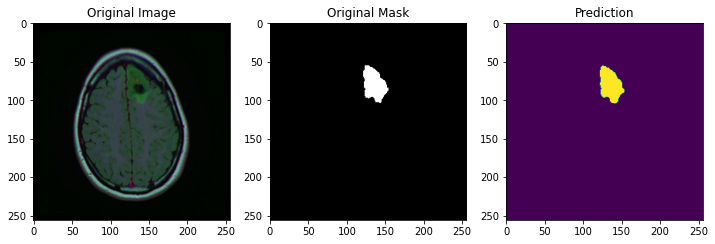

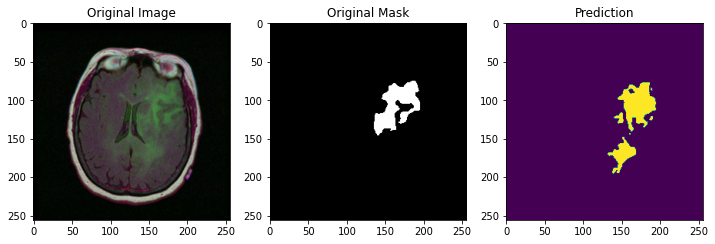

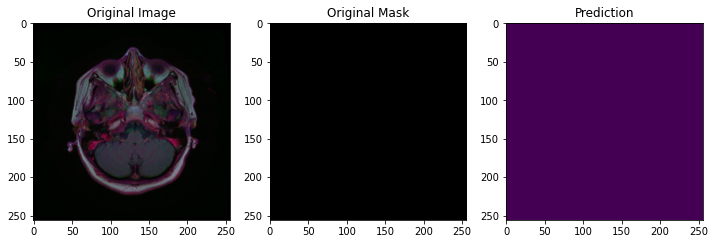

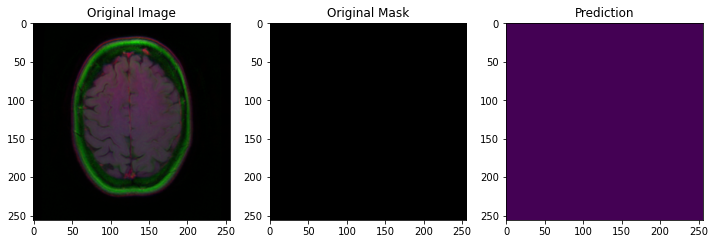

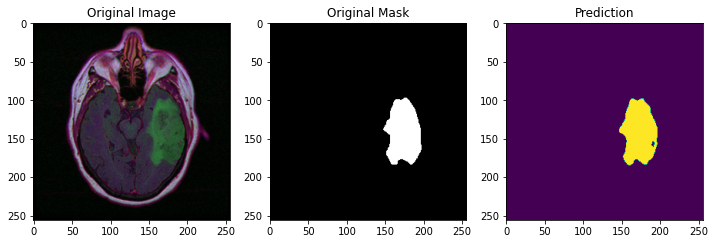

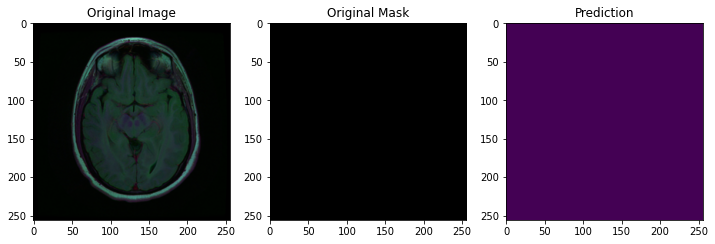

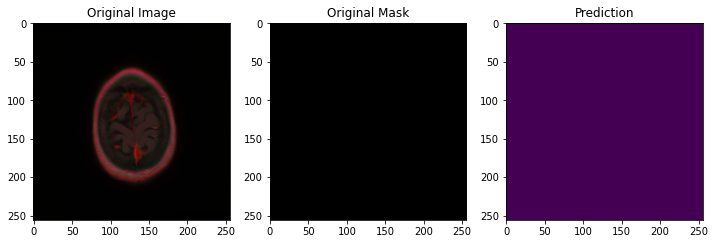

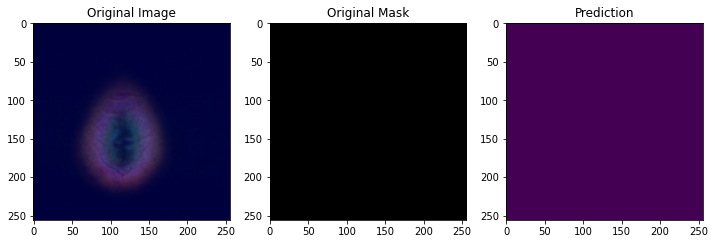

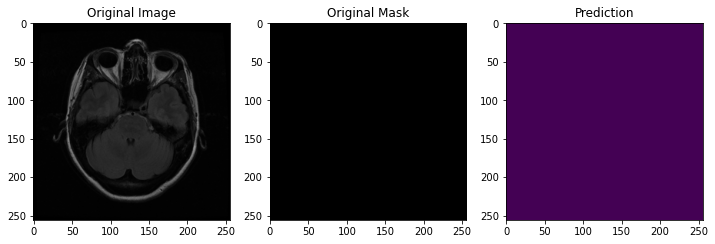

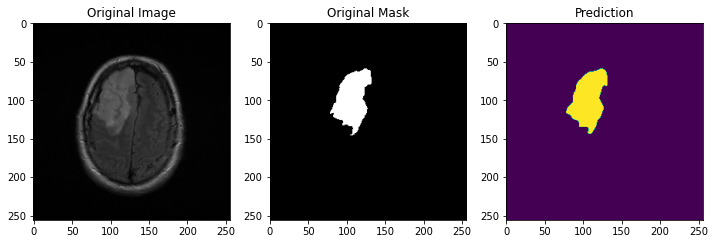

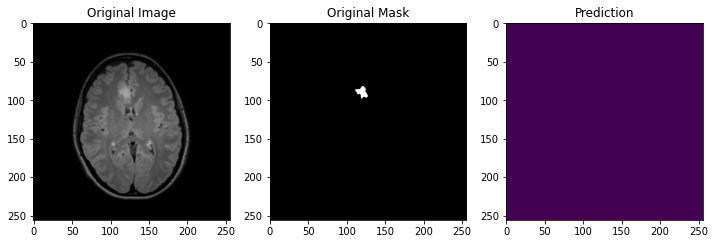

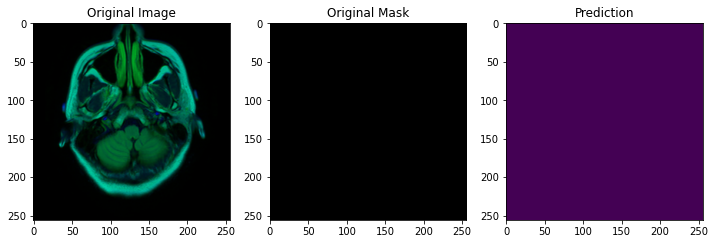

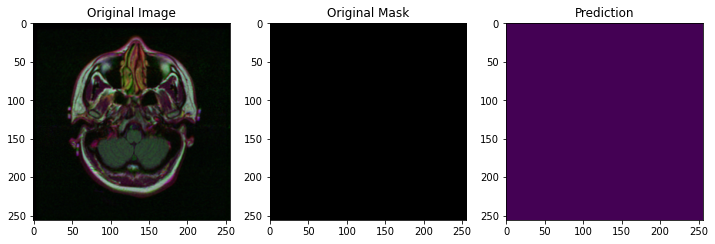

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()